## Teleseismic data and comparison

In [1]:
# load module
%matplotlib notebook
import instaseis
import numpy as np
import matplotlib.pyplot as plt
import h5py
import obspy
from obspy import read
from obspy.taup import TauPyModel as taup
from obspy.taup.taup_geo import calc_dist_azi as calc_dist_azi
from obspy.clients.fdsn import Client
from obspy.signal.cross_correlation import correlate
from obspy.signal.cross_correlation import xcorr_max

In [27]:
#%% model results
folder = '/import/schreck-data/dli/Mexico/Launch_Seissol/smallslab/tele/'

# event
# strike, dip, rake
event_time = obspy.UTCDateTime(2014,4,18,14,27,24)
plane = np.array([284.27870761202905, 14.770730028829346, 88.72632960838966])

## hypocenter
elat = 17.397
elon = -100.972

## station locations
# sta = np.loadtxt(folder + 'stations.txt')
sta = np.loadtxt(folder + 'station_D39_72.txt');

slat = sta[:,0]
slon = sta[:,1]

print(len(slat))

db = instaseis.open_db("syngine://iasp91_2s") # downloaded IRIS mseed data
# load IRIS miniseed 
#seisdata = read(folder + '2014-04-18-mw73-guerrero-mexico-2.miniseed')

# info = calc_dist_azi(elat, elon, slat[0],slon[0],6370,0)
# print(info)

15


<IPython.core.display.Javascript object>


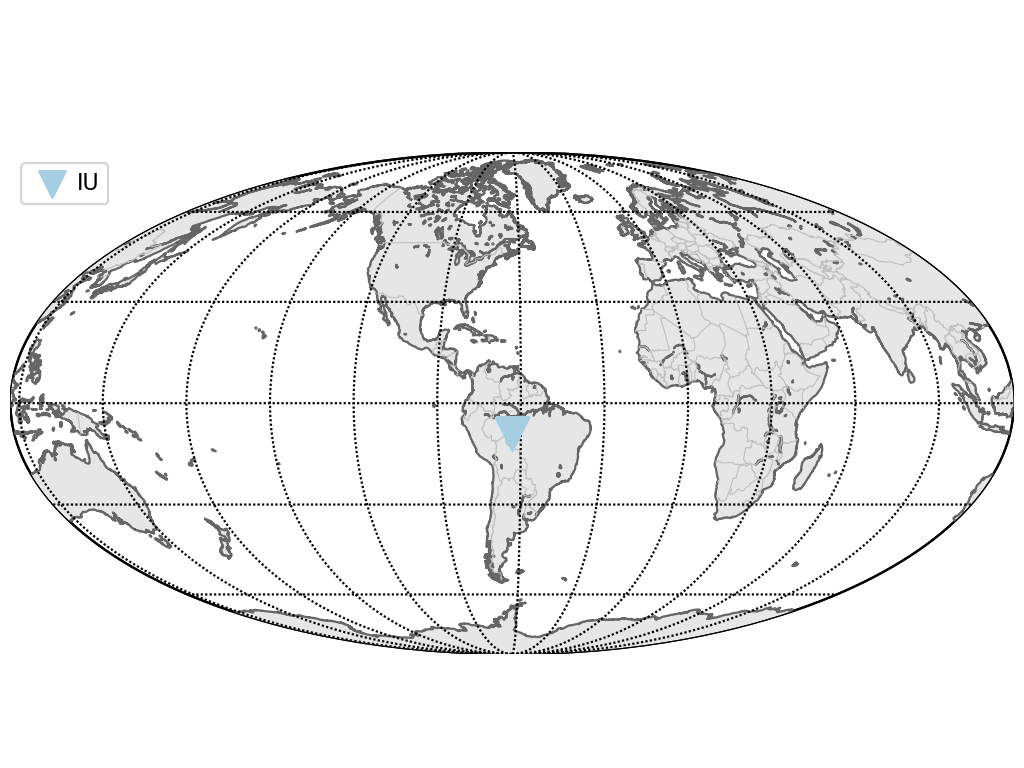

/home/dli/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<IPython.core.display.Javascript object>


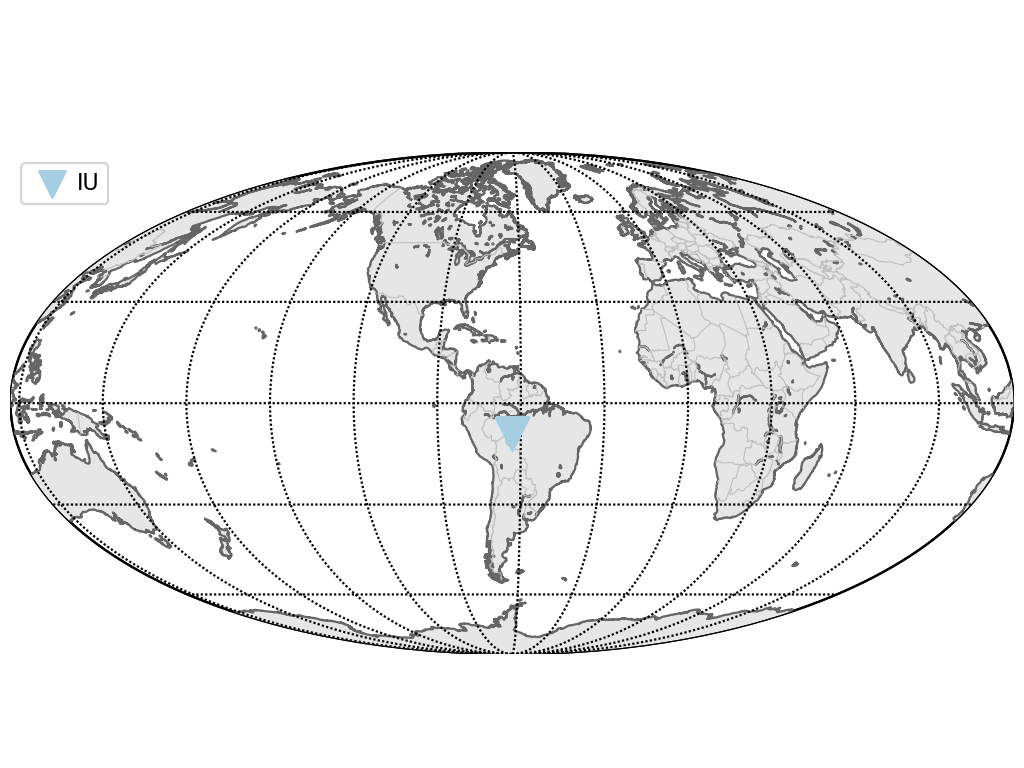

In [20]:
# TEST get iris data 
fdsn_client = Client('IRIS')
# event_time = obspy.UTCDateTime(2014,4,18,14,27,24)
ptime = 710.39
# sta = ['KBS','TARA','CMLA','HOPE','KDAK','FFC']

st = fdsn_client.get_waveforms(network='IU', station='SAML', location='00',
                               channel='BH*', starttime=event_time+ptime-60, endtime=event_time+ptime+120,
                               attach_response=True)

inv = fdsn_client.get_stations(network="I*", station='SAML',location='00', channel='BH*', level='channel',
                               starttime=event_time+ptime-60, endtime=event_time+ptime+120)
    
pre_filt = (0.005, 0.1, 30.0, 35.0)
st.remove_response(output='VEL', pre_filt=pre_filt)
st.rotate(method="->ZNE", inventory=inv) 

# print(st.select(channel="BHE")[0].times())
# print(st.select(channel="BHE")[0].data)
# print(st[0].stats)

inv.plot(projection="global", label=False,
         color_per_network=True) 

In [28]:
# print(seisdata)
# for ista in [1,2,3,4,5,7]:
    
# #     if (ista ==1):
# #         station = 'PAYG'
# #         net = 'IU'
        
# #     if (ista == 14):
# #         station = 'RSSD'
# #         net = 'IU'

#     if(ista == 1):
#         station = 'KBS'
#         net='IU'

#     if(ista == 2):
#         station = 'PTCN'
#         net = 'IU'
        
#     if (ista == 3):
#         station = 'TARA'
#         net='IU'
    
#     if (ista == 4):
#         station = 'CMLA'
#         net = 'II'
        
#     if (ista == 5):
#         station = 'HOPE'
#         net = 'II'
        
#     if (ista == 6):
#         station = 'KDAK'
#         net = 'II'
        
#     if (ista== 7):
#         net = 'II'
#         station = 'FFC'

# 2. station list of IU
stalist = ['PTGA','SAML','LVC','PTCN','POHA','KIP','COLA','XMAS','SFJD','JOHN','TRQA', 'ADK', 'RCBR', 'RAR','MIDW']
print(len(stalist))

for ista in range(0,len(stalist)):
#     taup get arrival time
    
    station = stalist[ista]
    print(station)
    net = 'IU'
    model = taup(model="iasp91")
    source_to_receiver = calc_dist_azi(elat, elon, slat[ista],slon[ista],6371,0)
    dist = round(source_to_receiver[0],2)
    azi  = round(source_to_receiver[1],2)
    
    arrivals = model.get_travel_times(source_depth_in_km=24,distance_in_degree=dist,phase_list=["P"])
    ptime = arrivals[0].time
    print(arrivals)
    
#     load data from IRIS
    
    seisdata = fdsn_client.get_waveforms(network = net, station = station, location = '00',
                               channel = 'BH*', starttime = event_time+ptime-60, endtime = event_time+ptime+120,
                               attach_response = True)
    starttime = seisdata.select(station=station,channel="BHZ")[0].stats.starttime
    
    inv = fdsn_client.get_stations(network=net, station=station,location='00', channel='BH*', level='channel',
                               starttime=event_time+ptime-60, endtime=event_time+ptime+120)
    seisdata.rotate(method="->ZNE", inventory=inv)   
    seisdata.rotate(method="NE->RT",back_azimuth=azi) 
    seisdata.resample(20.0)
#     print(seisdata)
    
#     using Instaseis to calculate seismograph
    receiver = instaseis.Receiver(latitude=slat[ista],longitude=slon[ista],network=net, station=station)
    source = instaseis.Source.from_strike_dip_rake(latitude=elat,longitude=elon,depth_in_m=24000.0,strike=plane[0],dip=plane[1],rake=plane[2],M0=9.4e19,origin_time=event_time)

    seismo0 = db.get_seismograms(source=source,receiver=receiver,dt=0.05,kind='velocity',components=('Z','N','E'))
    seismo0.filter('bandpass', freqmax=0.1, freqmin=0.005, corners=4, zerophase=True)
    seismo0.trim(starttime = event_time+ptime-60,endtime=event_time+ptime+120,nearest_sample=True)
    seismo0.taper(max_percentage=0.1)
    seismo0.rotate(method="NE->RT",back_azimuth=azi) 
#     print(seismo0)
            
    norm11 = np.max(seismo0.select(channel='BXZ')[0].data)
    norm12 = np.max(seismo0.select(channel='BXR')[0].data)
    norm13 = np.max(seismo0.select(channel='BXT')[0].data)
    norm1 = np.max([norm11,norm12,norm13])

#     IRIS data bandbass filter
    pre_filt = (0.005, 0.1, 30.0, 35.0)
    seisdata.remove_response(output='VEL', pre_filt=pre_filt)
    seisdata.filter('bandpass', freqmax=0.1, freqmin=0.005, corners=4, zerophase=True)    
    seisdata.taper(max_percentage=0.05)
    
    norm21 = np.max(seisdata.select(channel='BHZ')[0].data)
    norm22 = np.max(seisdata.select(channel='BHR')[0].data)
    norm23 = np.max(seisdata.select(channel='BHT')[0].data)
    norm2 = np.max([norm21,norm22,norm23])
    
    cc = correlate(seismo0.select(channel='BXZ')[0].data,seisdata.select(channel='BHZ')[0].data,600)
#     cc = correlate(seismo0[0].data,np.roll(seismo0[0].data,20),200)
    
    shift, value = xcorr_max(cc,abs_max=False)
    print(shift, value)   
    
    #     figure of comparison of synthetic and observation data
    fig,([ax0,ax1,ax2]) = plt.subplots(nrows=1,ncols=3,figsize=(12,2.0))

    ax0.plot(seismo0.select(channel='BXZ')[0].times(),seismo0.select(channel='BXZ')[0].data/norm1,'r')
    ax0.set_title('Z ')
    ax0.set_ylabel(station+' (' + str(dist)+','+str(azi)+')')
    ax0.set_ylim(-1,1)
    ax0.set_yticks([])
    ax0.plot(seisdata.select(channel='BHZ')[0].times(),np.roll(seisdata.select(channel='BHZ')[0].data/norm2,int(shift)),'k')
#     ax0.text(100,0.8, ,fontsize=12)

    ax1.plot(seismo0.select(channel='BXR')[0].times(),seismo0.select(channel='BXR')[0].data/norm1,'r')
    ax1.set_title('R ')
    ax1.set_ylim(-1,1)
    ax1.set_yticks([])
    ax1.plot(seisdata.select(channel='BHR')[0].times(),np.roll(seisdata.select(channel='BHR')[0].data/norm2,int(shift)),'k')
#     ax1.text(150,0.8,'cc='+str(shift*seisdata.select(channel='BHZ')[0].stats.delta),fontsize=12)

    ax2.plot(seismo0.select(channel='BXT')[0].times(),seismo0.select(channel='BXT')[0].data/norm1,'r')
    ax2.set_title('T ')
    ax2.set_ylim(-1,1)
    ax2.set_yticks([])
    ax2.plot(seisdata.select(channel='BHT')[0].times(),np.roll(seisdata.select(channel='BHT')[0].data/norm2,int(shift)),'k')
#     ax2.text(150,0.8,'cc='+str(shift*seisdata.select(channel='BHZ')[0].stats.delta),fontsize=12)

    plt.show()
    outname = 'tele/seismo_'+station+'_'+net+'.eps'
    plt.savefig(outname,dpi=100,format='eps',transparent=False)

print('finished')

15
PTGA
1 arrivals
	P phase arrival at 487.302 seconds
-116.5 0.7007835200700178


<IPython.core.display.Javascript object>

SAML
1 arrivals
	P phase arrival at 498.838 seconds
-83.5 0.7915569301104685


<IPython.core.display.Javascript object>

LVC
1 arrivals
	P phase arrival at 538.444 seconds
-126.5 0.6358192237826875


<IPython.core.display.Javascript object>

PTCN
1 arrivals
	P phase arrival at 540.251 seconds
-334.5 0.27854903388869906


<IPython.core.display.Javascript object>

POHA
1 arrivals
	P phase arrival at 543.852 seconds
-83.5 0.5904372117960534


<IPython.core.display.Javascript object>

KIP
1 arrivals
	P phase arrival at 559.482 seconds
-86.5 0.47948431610481373


<IPython.core.display.Javascript object>

COLA
1 arrivals
	P phase arrival at 582.142 seconds
-50.5 0.393492614362593


<IPython.core.display.Javascript object>

XMAS
1 arrivals
	P phase arrival at 587.025 seconds
-72.5 0.5296480017262009


<IPython.core.display.Javascript object>

SFJD
1 arrivals
	P phase arrival at 598.494 seconds
-50.5 0.5093535727789286


<IPython.core.display.Javascript object>

JOHN
1 arrivals
	P phase arrival at 638.986 seconds
-63.5 0.48007863965543884


<IPython.core.display.Javascript object>

TRQA
1 arrivals
	P phase arrival at 647.241 seconds
159.5 0.33715079045038104


<IPython.core.display.Javascript object>

ADK
1 arrivals
	P phase arrival at 654.810 seconds
-43.5 0.3334064059471796


<IPython.core.display.Javascript object>

RCBR
1 arrivals
	P phase arrival at 659.025 seconds
-120.5 0.7408994750352516


<IPython.core.display.Javascript object>

RAR
1 arrivals
	P phase arrival at 665.567 seconds
-55.5 0.45427470029489997


<IPython.core.display.Javascript object>

MIDW
1 arrivals
	P phase arrival at 670.680 seconds


FDSNNoDataException: No data available for request.
Detailed response of server:



In [97]:
print(seismo0.select(channel='BXZ')[0])
print(seisdata.select(channel='BHZ')[0])

II.CMLA..BXZ | 2014-04-18T14:37:21.900000Z - 2014-04-18T14:40:21.900000Z | 20.0 Hz, 3601 samples
II.CMLA.00.BHZ | 2014-04-18T14:37:21.919500Z - 2014-04-18T14:40:21.869500Z | 20.0 Hz, 3600 samples


In [ ]:
#%% load IRIS mseed data
# fdsn_client = Client('IRIS')
# event_time = obspy.UTCDateTime(2014,4,18,14,27,24)

# st = fdsn_client.get_waveforms(network='II', station='CMLA', location='00',
#                                channel='BHZ', starttime=event_time+ptime-60, endtime=event_time+ptime+120,
#                                attach_response=True)

# pre_filt = (0.005, 0.006, 30.0, 35.0)
# st.remove_response(output='VEL', pre_filt=pre_filt)

# st.plot()

In [117]:
np.sqrt(0.4)

0.63245553203367588

<IPython.core.display.Javascript object>


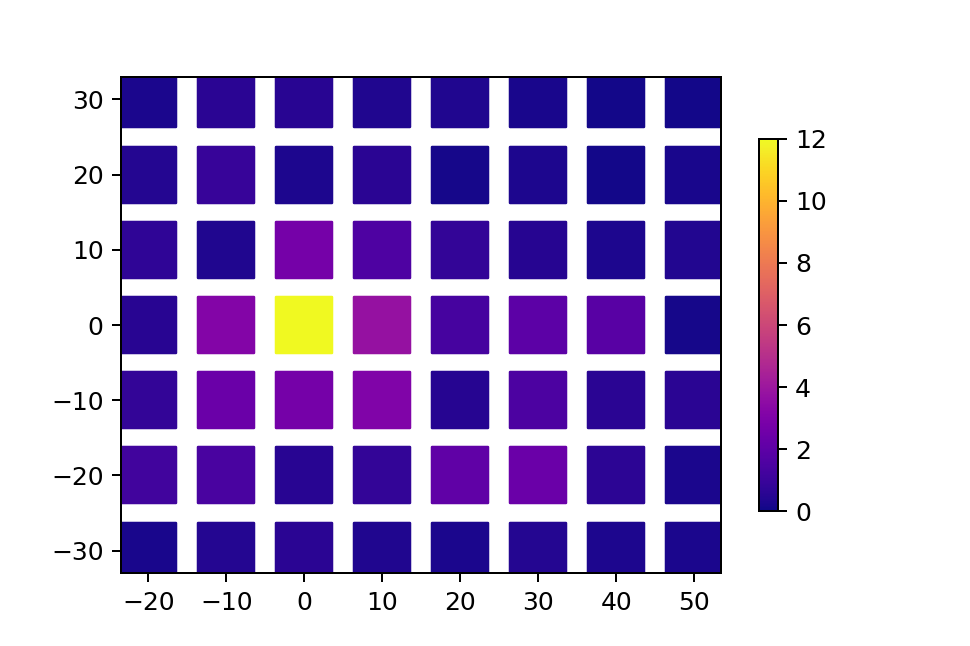

In [20]:
#%% Ye 2016 

stress = np.loadtxt(folder + 'stress_drop.txt',comments='#')

fig,ax0= plt.subplots(nrows=1,ncols=1,figsize=(3,2))

sc = ax0.scatter(stress[:,0],stress[:,1],s=500,c=stress[:,3],marker='s',cmap='plasma',vmin=0,vmax=12)
cl = fig.colorbar(sc,ax=ax0,shrink=0.75)

plt.show()


In [ ]:
print('finished')